## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)
import matplotlib.patches as patches

plt.style.use('fivethirtyeight')

In [2]:
import os
os.environ['SPARK_HOME'] = os.path.join(os.path.expanduser('~'), 'spark')
import findspark
findspark.init()

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    plt.draw()
    plt.show()

## Start Spark

In [4]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'
os.environ['SPARK_DRIVER_MEMORY'] = '8G'

In [5]:
import pyspark
from pyspark import SparkContext, SparkConf
import pynbody
import sparkhpc

In [34]:
%%writefile job.template
#!/bin/sh
#BSUB -J {jobname}
#BSUB -W {walltime} # runtime to request
#BSUB -o {jobname}-%J.log # output extra o means overwrite
#BSUB -n {ncores} # requesting ncores cores
#BSUB -R "rusage[mem={memory}]" # take any available core with mem MB of memory

# setup the spark paths
export SPARK_HOME={spark_home}
export SPARK_LOCAL_DIRS=$__LSF_JOB_TMPDIR__
export LOCAL_DIRS=$SPARK_LOCAL_DIRS
export SPARK_WORKER_DIR=$__LSF_JOB_TMPDIR__/work
#export SPARK_CONF_DIR=/cluster/home/roskarr/Projects/spark-fof/conf

sparkcluster launch --memory {memory}M

Overwriting job.template


In [6]:
#sj = sparkhpc.sparkjob.LSFSparkJob(ncores=27, memory=5500, walltime='4:00', template='./job.template')
#sj = sparkhpc.sparkjob.LSFSparkJob(ncores=27,memory=8500,walltime='3:00')
sj = sparkhpc.sparkjob.LSFSparkJob(clusterid=0)

In [7]:
sc = sparkhpc.start_spark(master=sj.master_url, spark_conf='../conf', profiling=True, executor_memory='8G')

### Make the base RDD

In [61]:
%time limits = p_rdd.mapPartitionsWithIndex(get_minmax).collect()

CPU times: user 23 ms, sys: 4 ms, total: 27 ms
Wall time: 55.8 s


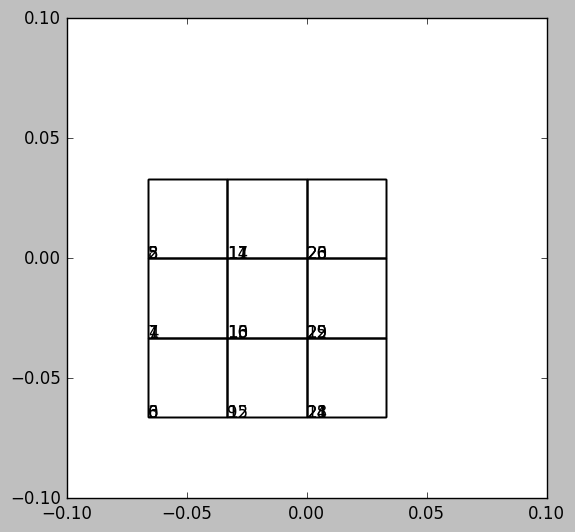

In [64]:
ax = plt.subplot(aspect='equal')
for i in range(len(limits)):
    x = 0
    y = 2
    mins = limits[i][1][0]
    maxs = limits[i][1][1]
    size = maxs-mins
    ax.add_patch(patches.Rectangle((mins[x],mins[y]),size[0], size[1], fill=False))
    ax.text(mins[x],mins[y], str(i))
ax.set_xlim(-0.1,.1)
ax.set_ylim(-.1,.1)
plt.draw()
plt.show()

### Preliminaries, setting the domain size and global grid mapping

In [17]:
#diff = (limits[0][1][1] - limits[0][1][0])[0]

### Run FOF and Merge groups

In [17]:
import spark_fof

In [22]:
reload(spark_fof.spark_fof)
reload(spark_fof)
reload(spark_fof.spark_fof_c)

<module 'spark_fof.spark_fof_c' from '/cluster/project/sis/ri/roskarr/spark-fof/spark_fof/spark_fof_c.so'>

In [ ]:
%%time
#path = '/cluster/home/roskarr/work/2Tlc-final/'
path = '/cluster/home/roskarr/projects/euclid/2Tlc-final/'

# domain parameters
diff = np.float32(0.033068776)
global_min = -31*diff
global_max = 31*diff

dom_maxs = np.array([global_max]*3, dtype=np.float64)
dom_mins = np.array([global_min]*3, dtype=np.float64)

#tau = diff*5./125.
tau = 0.2/12600
buffer_tau = diff*5./150.

fof_analyzer = spark_fof.spark_fof.LCFOFAnalyzer(sc, path, 64, 62, tau, dom_mins, dom_maxs, blockids=[30,31,32,33], buffer_tau=tau*2)
final_rdd = fof_analyzer.final_fof_rdd.cache()
final_rdd.count()

Number of input files:  55


In [24]:
def ghost_counts(index, iterator): 
    nghosts = 0
    nghosts_copy = 0
    nother = 0
    for arr in iterator: 
        nghosts += len(np.where(arr['is_ghost']==1)[0])
        nghosts_copy += len(np.where(arr['is_ghost']==2)[0])
        nother += len(np.where(arr['is_ghost']==0)[0])
    yield index,nother,nghosts,nghosts_copy

In [25]:
fof_rdd = fof_analyzer.fof_rdd

In [26]:
fof_rdd.cache().count()

15456

In [27]:
%load_ext memory_profiler

In [29]:
%memit groups = fof_analyzer._get_level_map()

peak memory: 5978.56 MiB, increment: 5271.09 MiB


In [84]:
import cPickle

In [86]:
cPickle.dump(groups, open('groups_map.pickle','w'))

In [ ]:
%%time
final_rdd = fof_analyzer.final_fof_rdd
final_rdd.count()

In [87]:
len(groups)

2876775

In [87]:
len(fof_analyzer2.groups)

1267851

In [89]:
sc.stop()
sj.stop()

INFO:sparkhpc:Job <33251605> is being terminated



In [88]:
sc.show_profiles()

Profile of RDD<id=171>
         1593 function calls in 0.014 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       81    0.002    0.000    0.011    0.000 rdd.py:1713(add_shuffle_key)
       27    0.002    0.000    0.005    0.000 broadcast.py:82(load)
       27    0.002    0.000    0.002    0.000 {cPickle.load}
       27    0.001    0.000    0.001    0.000 {open}
       27    0.001    0.000    0.001    0.000 {cPickle.dumps}
       54    0.001    0.000    0.001    0.000 serializers.py:143(_write_with_length)
       27    0.001    0.000    0.001    0.000 serializers.py:217(load_stream)
       27    0.000    0.000    0.001    0.000 rdd.py:61(portable_hash)
       27    0.000    0.000    0.006    0.000 broadcast.py:92(value)
       27    0.000    0.000    0.014    0.001 worker.py:165(process)
       54    0.000    0.000    0.001    0.000 serializers.py:155(_read_with_length)
       27    0.000    0.000    0.013